In [2]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

#Agenda:
#- IoU vecterization
#- .nonzero usage
#- Collect_fn
#- Map function and Zip function

# IoU vecterization

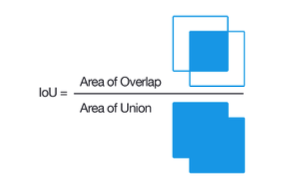

In [39]:
# this function will compute the IoU between one proposal and box
# xywh system
# input: 
    # prop_mat N*4
    # gt_mat M*4
# output:
    # IoU matrix: N*M
def IoU_para(prop_mat, gt_mat):
    if prop_mat.shape == (4,):
        prop_mat = prop_mat.reshape(1,-1)
    if gt_mat.shape == (4,):
        gt_mat = gt_mat.reshape(1,-1)
    
    # compute the range of the anchor box
    x_p_min = (prop_mat[:,0] - prop_mat[:,2]/2).reshape(-1,1)
    x_p_max = (prop_mat[:,0] + prop_mat[:,2]/2).reshape(-1,1)
    
    y_p_min = (prop_mat[:,1] - prop_mat[:,3]/2).reshape(-1,1)
    y_p_max = (prop_mat[:,1] + prop_mat[:,3]/2).reshape(-1,1)
    # compute the anchor area
    area_p = (prop_mat[:,2] * prop_mat[:,3]).reshape(-1,1)
    
    # compute the range of the gt bounding box
    x_gt_min = (gt_mat[:,0] - gt_mat[:,2]/2).reshape(-1,1)
    x_gt_max = (gt_mat[:,0] + gt_mat[:,2]/2).reshape(-1,1)
    y_gt_min = (gt_mat[:,1] - gt_mat[:,3]/2).reshape(-1,1)
    y_gt_max = (gt_mat[:,1] + gt_mat[:,3]/2).reshape(-1,1)
    # compute the gt area
    area_gt = (gt_mat[:,2] * gt_mat[:,3]).reshape(-1,1)
    
    # print(x_p_max)
    # print(x_gt_max.T)
    # print(np.minimum(x_p_max, x_gt_max.T))
    # compute the intersect w & h
    intersect_p_gt_w = np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0)  
    intersect_p_gt_h = np.maximum(np.minimum(y_p_max, y_gt_max.T) - np.maximum(y_p_min, y_gt_min.T), 0)
    # compute intersect area
    area_intersect = intersect_p_gt_w * intersect_p_gt_h
    
    # compute union area
    area_union = (area_p + area_gt.T) - area_intersect
    
    IoU = area_intersect / area_union
    return IoU




# # test for IoU
print("test for IoU---------------------")
start = time.time()


# prop_mat = torch.tensor([[2,0,4,4],
#                          [0,0,4,4]],dtype = torch.float)

# gt_mat = torch.tensor([[0,0,4,4],
#                        [2,0,4,4]],dtype = torch.float)
# IoU_matrix = IoU_para(prop_mat,gt_mat)
# break

rand_tensor_1 = torch.rand(100,4)
rand_tensor_2 = torch.rand(1000,4)

IoU_matrix_para = IoU_para(rand_tensor_1, rand_tensor_2)

print("IoU_matrix_para",IoU_matrix_para.shape)

print('time(s) for parallel IoU computation\n', time.time() - start)
print(IoU_matrix_para)

print()
print()

def IoU_fix_grid(pred_x,pred_y,pred_w,pred_h,gt_x,gt_y,gt_w,gt_h):
    # compute the range of the pred bounding box
    pred_x_min = pred_x-pred_w/2
    pred_x_max = pred_x+pred_w/2
    pred_y_min = pred_y-pred_h/2
    pred_y_max = pred_y+pred_h/2
    # compute the pred area
    pred_area = pred_w*pred_h
    
    # compute the range of the pred bounding box
    gt_x_min = gt_x - gt_w/2
    gt_x_max = gt_x + gt_w/2
    gt_y_min = gt_y - gt_h/2
    gt_y_max = gt_y + gt_h/2 
    # compute the pred area
    gt_area = gt_w*gt_h
    # compute the intersect w & h
    intersect_pred_gt_w = max(0,min(pred_x_max,gt_x_max)-max(pred_x_min,gt_x_min))
    intersect_pred_gt_h = max(0,min(pred_y_max,gt_y_max)-max(pred_y_min,gt_y_min))
    # compute intersect area
    intersect_area = intersect_pred_gt_w*intersect_pred_gt_h
    # compute union area
    union_area = pred_area + gt_area - intersect_area
    IoU_fix_grid = intersect_area/union_area
    return IoU_fix_grid

start_seq = time.time()
IoU_matrix_seq = torch.zeros((len(rand_tensor_1), len(rand_tensor_2)))
for ind1, box_pred in enumerate(rand_tensor_1):
  for ind2, box_gt in enumerate(rand_tensor_2):
    x1,y1,w1,h1 = box_pred
    x2,y2,w2,h2 = box_gt
    IoU_matrix_seq[ind1, ind2] = IoU_fix_grid(x1,y1,w1,h1,x2,y2,w2,h2)
print("IoU_matrix_seq",IoU_matrix_seq.shape)
print('time(s) for sequential IoU\n', time.time() - start_seq)
# print(IoU_matrix_seq)
print()
print('check if they are the same\n', IoU_matrix_seq== IoU_matrix_para)

test for IoU---------------------
IoU_matrix_para torch.Size([100, 1000])
time(s) for parallel IoU computation
 0.00680088996887207
tensor([[0.1933, 0.3674, 0.3034,  ..., 0.0012, 0.0010, 0.0857],
        [0.0000, 0.0000, 0.0258,  ..., 0.0065, 0.0000, 0.0557],
        [0.0000, 0.0026, 0.0133,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0143, 0.0000, 0.0075,  ..., 0.0000, 0.0000, 0.0000],
        [0.0020, 0.1005, 0.5343,  ..., 0.0180, 0.0225, 0.1638],
        [0.0000, 0.0000, 0.1465,  ..., 0.0000, 0.0000, 0.0000]])


IoU_matrix_seq torch.Size([100, 1000])
time(s) for sequential IoU
 14.334216833114624

check if they are the same
 tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


# Trick we could use in Vecterization

In [28]:
zeros = torch.zeros((8,8,8))
zeros[:,2,2] = 1
zeros[:,2,3] = 2

print(zeros)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 2., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 2., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 2., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
       

In [40]:
index = (zeros[0,:,:]==0).nonzero()
print('nonzeros indexing', index)
print(zeros[:, index[:,0], index[:,1]])


nonzeros indexing tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5],
        [0, 6],
        [0, 7],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [1, 4],
        [1, 5],
        [1, 6],
        [1, 7],
        [2, 0],
        [2, 1],
        [2, 4],
        [2, 5],
        [2, 6],
        [2, 7],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 3],
        [3, 4],
        [3, 5],
        [3, 6],
        [3, 7],
        [4, 0],
        [4, 1],
        [4, 2],
        [4, 3],
        [4, 4],
        [4, 5],
        [4, 6],
        [4, 7],
        [5, 0],
        [5, 1],
        [5, 2],
        [5, 3],
        [5, 4],
        [5, 5],
        [5, 6],
        [5, 7],
        [6, 0],
        [6, 1],
        [6, 2],
        [6, 3],
        [6, 4],
        [6, 5],
        [6, 6],
        [6, 7],
        [7, 0],
        [7, 1],
        [7, 2],
        [7, 3],
        [7, 4],
        [7, 5],
        [7, 6],
      

# How to read data on the file (Official code block)

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file) # annotation is small can load all at once.
        self.root_dir = root_dir # images are large, better to read on-the-fly.
        self.transform = transform # transformation list from torchvision.

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Collect_fn usage, based on last Homework

In [41]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr': 'test_y_label.npz'       }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Mounted at /content/drive


In [47]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        ## indicate the path for different dataset
        # imgs & mask data is h5 format
        # labels & bboxes data is npy format
        imgs_path, labels_path = self.path
        # load the data coarse data
        self.imgs_data = np.load(imgs_path, allow_pickle=True)["arr_0"]
        self.labels_data = np.load(labels_path, allow_pickle=True,encoding="latin1")["arr_0"]


    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox
        # img is the original img for the visualization
    def __getitem__(self, index):

        img = torch.tensor(self.imgs_data[index]/255, dtype = torch.float)
        label = torch.tensor(self.labels_data[index], dtype = torch.float)

        return img, label
    def __len__(self):
        return len(self.imgs_data)


class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
    
    # output:
        # img: (bz, 3, 800, 1088)
        # label_list: list, len:bz, each ()
        # transed_mask_list: list, len:bz, each (n_obj, 800,1088)
        # transed_bbox_list: list, len:bz, each (n_obj, 4)
        # img: (bz, 3, 300, 400)
    def collect_fn(self, batch):
        transed_img_list = []
        label_list = []

        for transed_img, label in batch:
            transed_img_list.append(transed_img)
            label_list.append(label)

        return torch.stack(transed_img_list, dim=0),\
               label_list
    
    def loader(self):
        return DataLoader(self.dataset,
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          num_workers=self.num_workers,
                          collate_fn=self.collect_fn)
        # return DataLoader(self.dataset,
        #                   batch_size=self.batch_size,
        #                   shuffle=self.shuffle,
        #                   num_workers=self.num_workers)


if __name__ == '__main__':
    # file path and make a list
    imgs_path = './images.npz'
    labels_path = './labels.npz'
    paths = [imgs_path, labels_path]
    # load the data into data.Dataset
    dataset = BuildDataset(paths)

    ## Visualize debugging
    # --------------------------------------------
    # build the dataloader
    # set 20% of the dataset as the training data
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    # random split the dataset into training and testset
    # set seed
    torch.random.manual_seed(1)
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    print(len(train_dataset))
    # push the randomized training data into the dataloader
    batch_size = 2
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    train_loader = train_build_loader.loader()
    test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = test_build_loader.loader()
    
    # loop the image
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for iter, data in enumerate(train_loader, 0):
      print(str(iter)+'data loaded')
      img, label = [data[i] for i in range(len(data))]
      print('img.shape', img.shape)
      print('label.shape', [label_i.shape for label_i in label])


Streaming output truncated to the last 5000 lines.
label.shape [torch.Size([8, 5]), torch.Size([6, 5])]
2334data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([8, 5]), torch.Size([2, 5])]
2335data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([4, 5]), torch.Size([2, 5])]
2336data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([3, 5]), torch.Size([6, 5])]
2337data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([7, 5]), torch.Size([5, 5])]
2338data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([6, 5]), torch.Size([3, 5])]
2339data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([9, 5]), torch.Size([5, 5])]
2340data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([3, 5]), torch.Size([6, 5])]
2341data loaded
img.shape torch.Size([2, 128, 128, 3])
label.shape [torch.Size([3, 5]), torch.Size([6, 5])]
2342data loaded
img.shape torch.

# Map function and Zip function

## map function as a CPU parallel computation

In [46]:


def add(a,b):
    return [a+b, a-b]

list1 = torch.rand(100)
list2 = torch.rand(100)
start = time.time()
result = map(add, list1, list2)
print('CPU parallel time(s)\n', time.time() - start)
print(list(result))


result = []
start = time.time()
for i in range(len(list1)):
  result.append(add(list1[i], list2[i]))

print('seq computation time(s)\n', time.time()-start)
print(result)



CPU parallel time(s)
 0.0002300739288330078
[[tensor(0.7469), tensor(0.6783)], [tensor(1.3295), tensor(0.2467)], [tensor(1.2054), tensor(-0.4292)], [tensor(1.1487), tensor(0.2397)], [tensor(1.0620), tensor(-0.7599)], [tensor(1.0029), tensor(-0.4167)], [tensor(1.0081), tensor(-0.8867)], [tensor(0.7388), tensor(-0.0939)], [tensor(1.0224), tensor(-0.9608)], [tensor(1.1334), tensor(0.1128)], [tensor(1.2216), tensor(-0.7033)], [tensor(0.8469), tensor(0.0323)], [tensor(1.2424), tensor(0.6203)], [tensor(0.6429), tensor(0.5552)], [tensor(0.8771), tensor(-0.0954)], [tensor(1.1882), tensor(-0.6187)], [tensor(0.2732), tensor(0.2029)], [tensor(1.3928), tensor(-0.5505)], [tensor(0.6451), tensor(-0.6058)], [tensor(0.1206), tensor(0.1037)], [tensor(1.8545), tensor(0.0574)], [tensor(0.9611), tensor(0.0501)], [tensor(1.4936), tensor(-0.4381)], [tensor(0.6391), tensor(-0.5321)], [tensor(0.9347), tensor(0.8204)], [tensor(0.5420), tensor(0.1292)], [tensor(0.6703), tensor(0.6000)], [tensor(0.5831), tensor(

## Zip function basic usage, and dimension change of zip

In [ ]:
numbers = [1, 2, 3]
letters = ['a', 'b', 'c']
zipped = zip(numbers, letters)
for i in list(zipped):
  print(i)

(1, 'a')
(2, 'b')
(3, 'c')


In [ ]:
result = map(add, [1,2], [3,4])

for i in map(list, zip(*result)):
  print(i)


[4, 6]
[-2, -2]


In [45]:
test = [ [1,2,3],
         [4,5,6] ] # dim1: len2, dim2: len3

swap = [torch.tensor([dim2]) for dim2 in zip(*test)]
print(swap)
print(torch.cat(swap,0))

[tensor([[1, 4]]), tensor([[2, 5]]), tensor([[3, 6]])]
tensor([[1, 4],
        [2, 5],
        [3, 6]])
